# Email Spam Classification - CNN Model Training

This notebook builds, trains, and evaluates a CNN model for spam classification.

## Architecture:
- Embedding Layer
- Conv1D Layers
- MaxPooling
- Dense Layers with Dropout
- Binary Classification (Sigmoid)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 1. Load Preprocessed Data

In [2]:
# Load data
train_df = pd.read_csv('../data/preprocessed_train.csv')
test_df = pd.read_csv('../data/preprocessed_test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

print(f"\nTrain class distribution:")
print(train_df['Category'].value_counts())

Train shape: (4455, 6)
Test shape: (1114, 6)

Train class distribution:
Category
ham     3857
spam     598
Name: count, dtype: int64


In [3]:
# Define function to parse sequences correctly (handles missing closing bracket)
def parse_sequence(seq_str):
    """Parse sequence string from CSV (handles space-separated values, may be missing ])"""
    # Remove opening bracket if present
    seq_str = seq_str.replace('[', '').replace(']', '').strip()
    # Split by whitespace and convert to integers, filter out empty strings
    return np.array([int(x) for x in seq_str.split() if x])

# Convert sequence strings back to arrays
train_df['sequence'] = train_df['sequence'].apply(parse_sequence)
test_df['sequence'] = test_df['sequence'].apply(parse_sequence)

print(f"Train sequences shape: {train_df['sequence'].iloc[0].shape}")
print(f"Test sequences shape: {test_df['sequence'].iloc[0].shape}")

# Prepare training data
X_train = np.stack(train_df['sequence'].values)
y_train = train_df['label'].values

X_test = np.stack(test_df['sequence'].values)
y_test = test_df['label'].values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Train sequences shape: (100,)
Test sequences shape: (100,)

X_train shape: (4455, 100)
y_train shape: (4455,)
X_test shape: (1114, 100)
y_test shape: (1114,)


In [4]:
# Load tokenizer to get vocabulary size
with open('../data/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

VOCAB_SIZE = min(len(tokenizer.word_index) + 1, 10000)
MAX_SEQUENCE_LENGTH = X_train.shape[1]

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")

Vocabulary size: 7726
Max sequence length: 100


## 2. Build CNN Model

In [5]:
# Model hyperparameters
EMBEDDING_DIM = 128
FILTERS = 128
KERNEL_SIZE = 5
DROPOUT_RATE = 0.5

def create_cnn_model():
    """
    Create CNN model for spam classification.
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=VOCAB_SIZE, 
                  output_dim=EMBEDDING_DIM, 
                  input_length=MAX_SEQUENCE_LENGTH,
                  name='embedding'),
        
        # First Conv1D block
        Conv1D(filters=FILTERS, 
               kernel_size=KERNEL_SIZE, 
               activation='relu',
               name='conv1d_1'),
        MaxPooling1D(pool_size=2, name='maxpool_1'),
        Dropout(DROPOUT_RATE, name='dropout_1'),
        
        # Second Conv1D block
        Conv1D(filters=FILTERS, 
               kernel_size=KERNEL_SIZE, 
               activation='relu',
               name='conv1d_2'),
        GlobalMaxPooling1D(name='global_maxpool'),
        
        # Dense layers
        Dense(64, activation='relu', name='dense_1'),
        BatchNormalization(name='batch_norm'),
        Dropout(DROPOUT_RATE, name='dropout_2'),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Create model
model = create_cnn_model()

# Display model architecture
model.summary()

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_maxpool (GlobalMaxPooling1D)  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm (BatchNormalization)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Visualize model architecture
# Build the model first (needs to know input shape)
model.build(input_shape=(None, 100))

# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=70)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## 3. Compile and Train Model

In [7]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("Model compiled successfully!")

Model compiled successfully!


In [8]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='../model/saved_models/spam_classifier.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [9]:
# Train model
BATCH_SIZE = 64
EPOCHS = 20
VALIDATION_SPLIT = 0.1

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6686 - loss: 0.6156 - precision: 0.2560 - recall: 0.6973
Epoch 1: val_accuracy improved from -inf to 0.85874, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6702 - loss: 0.6138 - precision: 0.2573 - recall: 0.6987 - val_accuracy: 0.8587 - val_loss: 0.4508 - val_precision: 1.0000 - val_recall: 0.0870 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9737 - loss: 0.1638 - precision: 0.8981 - recall: 0.9153
Epoch 2: val_accuracy improved from 0.85874 to 0.93274, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9738 - loss: 0.1632 - precision: 0.8985 - recall: 0.9154 - val_accuracy: 0.9327 - val_loss: 0.2514 - val_precision: 1.0000 - val_recall: 0.5652 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9923 - loss: 0.0541 - precision: 0.9908 - recall: 0.9532
Epoch 3: val_accuracy improved from 0.93274 to 0.95516, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9923 - loss: 0.0540 - precision: 0.9908 - recall: 0.9533 - val_accuracy: 0.9552 - val_loss: 0.1560 - val_precision: 1.0000 - val_recall: 0.7101 - learning_rate: 0.0010
Epoch 4/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9945 - loss: 0.0319 - precision: 0.9921 - recall: 0.9677
Epoch 4: val_accuracy improved from 0.95516 to 0.97085, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9945 - loss: 0.0318 - precision: 0.9921 - recall: 0.9680 - val_accuracy: 0.9709 - val_loss: 0.1137 - val_precision: 1.0000 - val_recall: 0.8116 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9978 - loss: 0.0178 - precision: 0.9982 - recall: 0.9861
Epoch 5: val_accuracy improved from 0.97085 to 0.97534, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9978 - loss: 0.0177 - precision: 0.9982 - recall: 0.9861 - val_accuracy: 0.9753 - val_loss: 0.0980 - val_precision: 1.0000 - val_recall: 0.8406 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9985 - loss: 0.0120 - precision: 0.9992 - recall: 0.9898
Epoch 6: val_accuracy improved from 0.97534 to 0.97982, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9985 - loss: 0.0120 - precision: 0.9992 - recall: 0.9899 - val_accuracy: 0.9798 - val_loss: 0.0862 - val_precision: 1.0000 - val_recall: 0.8696 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9993 - loss: 0.0080 - precision: 1.0000 - recall: 0.9953
Epoch 7: val_accuracy improved from 0.97982 to 0.98430, saving model to ../model/saved_models/spam_classifier.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9994 - loss: 0.0080 - precision: 1.0000 - recall: 0.9953 - val_accuracy: 0.9843 - val_loss: 0.0762 - val_precision: 1.0000 - val_recall: 0.8986 - learning_rate: 0.0010
Epoch 8/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9981 - loss: 0.0053 - precision: 1.0000 - recall: 0.9860
Epoch 8: val_accuracy did not improve from 0.98430
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9982 - loss: 0.0053 - precision: 1.0000 - recall: 0.9863 - val_accuracy: 0.9798 - val_loss: 0.0856 - val_precision: 0.9839 - val_recall: 0.8841 - learning_rate: 0.0010
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0028 - precision: 1.0000 - recall: 1.0000
Epoch 9: val_accuracy did not improve from 0.98430
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 1.0000 - loss: 0.0028 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9821 - val_loss: 0.0834 - val_precision: 0.9841 - val_recall: 0.8986 - learning_r

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 1.0000 - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9865 - val_loss: 0.0829 - val_precision: 1.0000 - val_recall: 0.9130 - learning_rate: 5.0000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


## 4. Visualize Training History

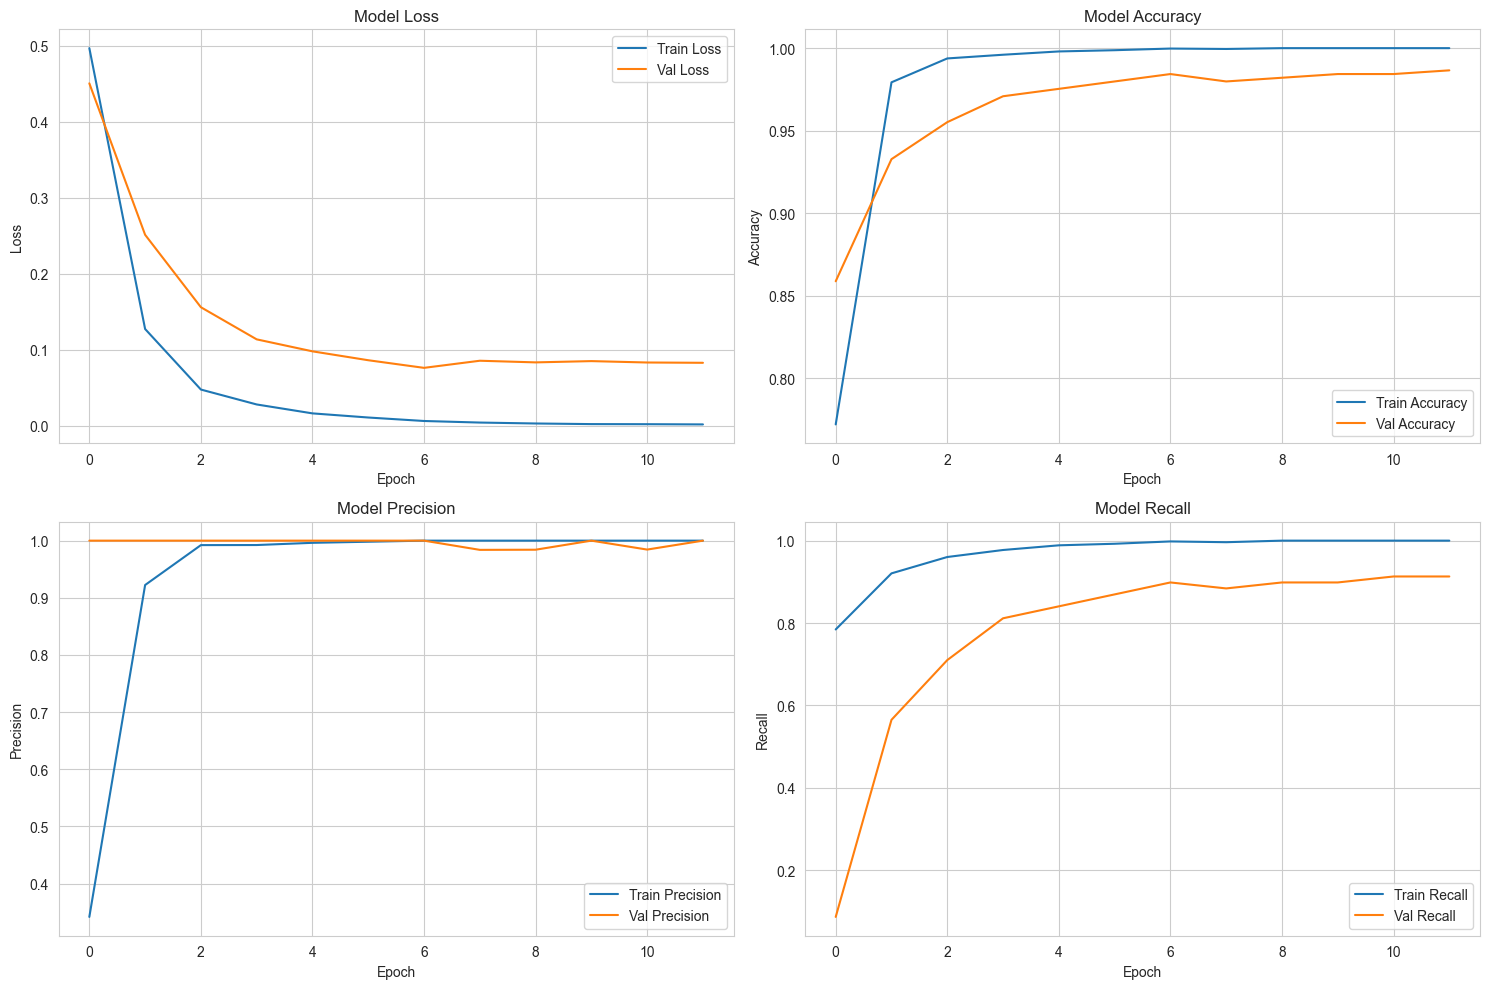

In [10]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 5. Evaluate on Test Set

In [11]:
# Evaluate model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1)

print(f"\n{'='*50}")
print(f"Test Results:")
print(f"{'='*50}")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9877 - loss: 0.0607 - precision: 0.9853 - recall: 0.9184

Test Results:
Loss: 0.0559
Accuracy: 0.9865 (98.65%)
Precision: 0.9786
Recall: 0.9195
F1-Score: 0.9481


In [12]:
# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       965
        Spam       0.98      0.92      0.95       149

    accuracy                           0.99      1114
   macro avg       0.98      0.96      0.97      1114
weighted avg       0.99      0.99      0.99      1114



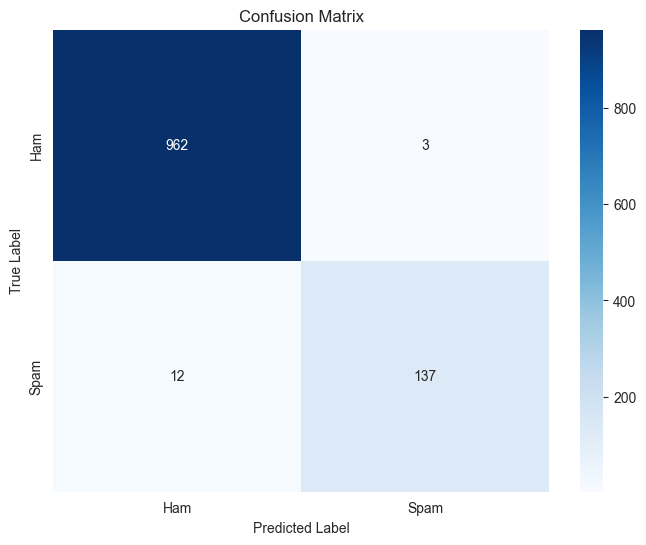


Confusion Matrix Breakdown:
True Negatives (Ham correctly classified): 962
False Positives (Ham misclassified as Spam): 3
False Negatives (Spam misclassified as Ham): 12
True Positives (Spam correctly classified): 137


In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate percentages
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Ham correctly classified): {tn}")
print(f"False Positives (Ham misclassified as Spam): {fp}")
print(f"False Negatives (Spam misclassified as Ham): {fn}")
print(f"True Positives (Spam correctly classified): {tp}")

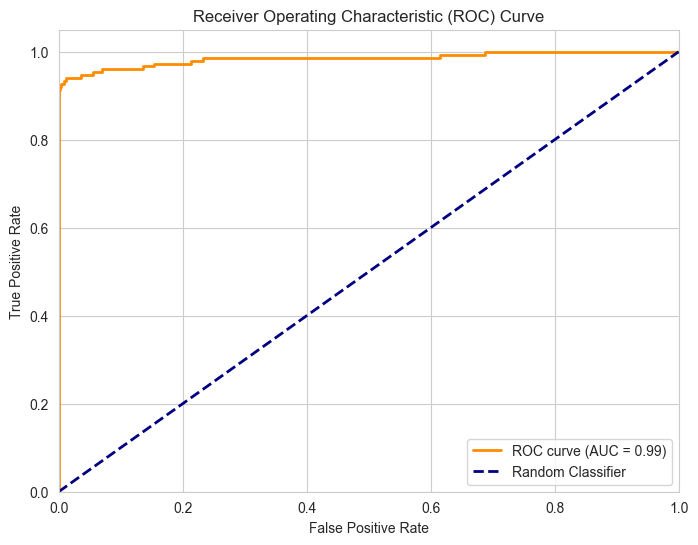

In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 6. Test on Sample Messages

In [15]:
# Test on new messages
test_messages = [
    "Congratulations! You've won a FREE iPhone! Click here to claim your prize now!",
    "Hi, can we schedule a meeting for tomorrow at 3pm?",
    "URGENT! Your account will be closed. Call now 1-800-WINNER",
    "Don't forget to bring the documents for our meeting",
    "FREE MONEY! Text WIN to 12345 to receive $1000 instantly!",
    "I would like to return my damaged product. How can I proceed?"
]

# Preprocess messages
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\b\d{10,}\b', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_messages = [clean_text(msg) for msg in test_messages]
sequences = tokenizer.texts_to_sequences(cleaned_messages)
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Predict
predictions = model.predict(padded)

# Display results
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

for msg, prob in zip(test_messages, predictions):
    pred_class = 'SPAM' if prob[0] > 0.5 else 'HAM'
    confidence = prob[0] if prob[0] > 0.5 else 1 - prob[0]
    print(f"\nMessage: {msg}")
    print(f"Prediction: {pred_class} (Confidence: {confidence*100:.2f}%)")
    print("-" * 80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step

SAMPLE PREDICTIONS

Message: Congratulations! You've won a FREE iPhone! Click here to claim your prize now!
Prediction: SPAM (Confidence: 100.00%)
--------------------------------------------------------------------------------

Message: Hi, can we schedule a meeting for tomorrow at 3pm?
Prediction: HAM (Confidence: 99.58%)
--------------------------------------------------------------------------------

Message: URGENT! Your account will be closed. Call now 1-800-WINNER
Prediction: HAM (Confidence: 64.89%)
--------------------------------------------------------------------------------

Message: Don't forget to bring the documents for our meeting
Prediction: HAM (Confidence: 99.49%)
--------------------------------------------------------------------------------

Message: FREE MONEY! Text WIN to 12345 to receive $1000 instantly!
Prediction: SPAM (Confidence: 86.20%)
--------------------------------------------------------------------------------

## 7. Save Model

In [17]:
# Save model (already saved by ModelCheckpoint callback, but save again to ensure)
model.save('../model/saved_models/spam_classifier.h5')

print("✅ Model saved to: ../model/saved_models/spam_classifier.h5")
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)

✅ Model saved to: ../model/saved_models/spam_classifier.h5

TRAINING COMPLETE!
